# Import Dataset and Libraries

In [162]:
%pip install catboost==1.1.1
%pip install pycountry==22.1.10
%pip install scikit-learn==1.2.2
%pip install optuna==3.2.0

Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following yanked versions: 0.1.1
ERROR: Could not find a version that satisfies the requirement catboost==1.1.1 (from versions: 1.2, 1.2.1, 1.2.1.1, 1.2.2, 1.2.3)
ERROR: No matching distribution found for catboost==1.1.1

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [163]:
import functools

import joblib
import numpy as np
import optuna
import pandas as pd
import pycountry
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score)
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

TRAIN_FILE = "./train.csv"
TEST_FILE = "./submission.csv"
MODEL_FILE = "./catboost_params.pkl"

DO_OPTIMIZATION = False
RANDOM_STATE = 42

In [164]:
df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)
df_submission = pd.read_csv(TEST_FILE)

X, y = df_train.drop("is_converted", axis=1), df_train["is_converted"]
X_test = df_test.drop(["is_converted", "id"], axis=1)

# Data Preprocessing

## 1. Data Imputation

In [165]:
values = {
    **{column: 0 for column in X.columns},
    "inquiry_type": "Quotation or Purchase Consultation",
    "customer_country": "Not Found",
}

X.fillna(value=values, inplace=True)
X_test.fillna(value=values, inplace=True)

## 2. Data Cleaning 

### Feature: Expected Timeline

In [166]:
def expected_timeline_remap(line):
    if not isinstance(line, str):
        return np.nan

    line = (
        line.lower()
        .strip()
        .replace("then", "than")
        .replace("_", "")
        .replace("~", "")
        .replace(" ", "")
        .replace("-", "")
    )

    if line in ["lessthan3months", "onemonth"]:
        return 1.5
    elif line in ["3months6months", "lessthan6months", "lessthan5months"]:
        return 4.5
    elif line == "6months9months":
        return 7.5
    elif line == "9months1year":
        return 10.5
    elif line == "morethanayear":
        return 12
    else:
        return np.nan


X["expected_timeline"] = [
    expected_timeline_remap(x) for x in X["expected_timeline"].values
]
X_test["expected_timeline"] = [
    expected_timeline_remap(x) for x in X_test["expected_timeline"].values
]

X["expected_timeline"].fillna(X["expected_timeline"].mean(), inplace=True)
X_test["expected_timeline"].fillna(X["expected_timeline"].mean(), inplace=True)

### Feature: Customer Country

In [167]:
def preprocess_country(country):
    if not isinstance(country, str):
        return "Not Found"

    country = country.split("/")[-1].strip()
    country = pycountry.countries.get(name=country)
    return "Not Found" if country is None else country.alpha_3


X["customer_country"] = [
    preprocess_country(country) for country in X["customer_country"]
]

X_test["customer_country"] = [
    preprocess_country(country) for country in X_test["customer_country"]
]

### Feature: Business Unit ("business_unit")

In [168]:
X["business_unit"] = X["business_unit"].astype(
    pd.CategoricalDtype(categories=["ID", "AS", "IT", "Solution", "CM"])
)
X_test["business_unit"] = X_test["business_unit"].astype(
    pd.CategoricalDtype(categories=["ID", "AS", "IT", "Solution", "CM"])
)

### Feature: Inquiry Type ("inquiry_type")

In [169]:
inquiry_type_remap = {
    # Quotation: Asking about the product itself.
    "Q": [
        "Quotation or Purchase Consultation",
        "Quotation or purchase consultation",
        "Quotation or Purchase consultation",
        "quotation_or_purchase_consultation",
        "Purchase or Quotation",
        "Purchase",
        "Request for quotation or purchase",
        "Sales Inquiry",
        "sales",
        "quotation_",
    ],
    # Usage: Asking about how to use the product.
    "U": [
        "Usage or Technical Consultation",
        "Usage or technical consultation",
        "usage or technical consultation",
        "usage_or_technical_consultation",
        "Technical Consultation",
        "Technical Support",
        "technical",
        "technical_consultation",
        "Request for technical consulting",
        "Product Information",
        "i want to know the details about it",
        "first Info and pricing",
        "Toi muon tim hieu thong tin ky thuat, gia ca cua sp de su dung",
        "tôi cần tham khảo giá và giải pháp từ LG",
        "Trainings",
    ],
    "O": [
        "Other",
        "Others",
        "other_",
        "other",
        "others",
        "Etc.",
        "ETC.",
        "Not specified",
        "(Select ID_Needs)",
        "IDB",
        "Services",
        "Request for Partnership",
        "Request a Demo",
        "Request for Distributorship",
        "Customer Suggestions",
        *(
            df_train["inquiry_type"]
            .value_counts()
            .loc[df_train["inquiry_type"].value_counts() < 10]
            .index.tolist()
        ),
    ],
}

for key, value in inquiry_type_remap.items():
    X.loc[X["inquiry_type"].isin(value), "inquiry_type"] = key
    X_test.loc[X_test["inquiry_type"].isin(value), "inquiry_type"] = key

### Feature: Customer Position ("customer_position")

In [170]:
X['customer_position'] = X['customer_position'].replace('decision maker', 'decision-maker')
X['customer_position'] = X['customer_position'].replace('decision influencer', 'decision-influencer')
X['customer_position'] = X['customer_position'].replace('architect/consultant', 'architecture/consult')
X['customer_position'] = X['customer_position'].replace('physics and mathematics teacher', 'math and physics teacher')
X['customer_position'] = X['customer_position'].replace('vicepresident', 'vice president')
X['customer_position'] = X['customer_position'].replace('others', 'other')

X_test['customer_position'] = X_test['customer_position'].replace('decision influencer', 'decision-influencer')
X_test['customer_position'] = X_test['customer_position'].replace('architect/consultant', 'architecture/consult')
X_test['customer_position'] = X_test['customer_position'].replace('physics and mathematics teacher', 'math and physics teacher')
X_test['customer_position'] = X_test['customer_position'].replace('vicepresident', 'vice president')
X_test['customer_position'] = X_test['customer_position'].replace('others', 'other')

In [171]:
# Classification by position and occupation
C_position_high_executive = [
    'manager', 'ceo/founder', 'c-level executive',
    'vice president', 'c-levelexecutive', 'founder',
    'commercial consultant', 'government',
    'operations', 'other - please specify - cedia association',
    'leadership/executive office/owner', 'market intelligence/research',
    'chairman', 'co-founder', 'chief executive officer',
    'ceo/fundador', 'gerente', 'president', 'genel müdür', 'bulgaria',
]

C_position_low_executive = [
    'director', 'intern', 'trainee', 'entry level',
    'employee', 'administrative', 'manufacturer',
    'system integrator', 'distributor', 'business unit director',
    'business development', 'product management', 'business partner',
    'subsidiary sales (ise)', 'business development/sales',
    'sales',
]

C_position_education = [
    'physics teacher', 'assistant professor',
    'maths lecturer', 'science teacher', 'physics faculty',
    'teacher/middle school coordinator', 'math and physics teacher',
    'professor of mathematics', 'prof.', 'professor of mathematics',
    'academic specialist', 'principal at oxford integrated pu science college'
    'assistant professor of English', 'educator', 'professor',
    'quantitative aptitude faculty', 'english trainer for ielts,toefl,pte,gre,sat exams.'
    'associate professor', 'principal & director', 'hon dean',
    'pgt physics', 'education professional', 'chemistry teacher',
    'director cum faculty at gaining apex coaching centre',
    'academic coordinator/ post graduate teacher (accountancy, business studies)/ tgt (ict)',
    'teacher', 'senior lecturer', 'neet/ olympiad expert faculty',
    'asst prof.', 'associate professor in electronics engg', 'professional trainer',
    'education',
]

C_position_hospital = [
    'hospital', 'medical device manufacturer', 'vp', 'medical imaging specialist',
    'tierarzt', 'főorvos', 'surgery professional', 'pathologist', 'radiology professional'
]

C_position_others = [
    'entry level', 'customer', 'technical',
    'exhibition', 'end-user', 'cargo', 'técnico', 'exhibitiontv',
    'proprietário(a)', 'mindenes', 'research', 'the big boss',
    'partner', 'associate/analyst', 'none', 'unpaid', 'av management',
    'engineering', 'installer', 'homeowner', 'commercial end-user'
    'lider de desarrollo', 'entrepreneurship', 'not applicable',
    'no influence',
]

C_position_consultant = [
    'consultant', 'software/solution provider', 'guest faculty',
    'career coach', 'consulting',
]


In [172]:
position_category= {
    'High Executive': C_position_high_executive,
    'Low Executive': C_position_low_executive,
    'Education': C_position_education,
    'Hospital': C_position_hospital,
    'Consultant': C_position_consultant,
    'Others': C_position_others
}

for category, positions in position_category.items():
    X.loc[X['customer_position'].isin(positions), 'C_position_1'] = category
    X_test.loc[X_test['customer_position'].isin(positions), 'C_position_1'] = category

# 'Hospital', 'Consultant', 'Education'는 무의미한 데이터로 판단 -> Others로 대체
categories_drop = ['Hospital', 'Consultant', 'Education']
X.loc[X['C_position_1'].isin(categories_drop), 'C_position_1'] = 'Others'
X_test.loc[X_test['C_position_1'].isin(categories_drop), 'C_position_1'] = 'Others'

# C_position_category one_hot_encoding
X_encoded = pd.get_dummies(X, columns=['C_position_1'])
X_test_encoded = pd.get_dummies(X_test, columns=['C_position_1'])

C:\Users\kjmin\AppData\Local\Temp\ipykernel_8720\1130747203.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'High Executive' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.loc[X['customer_position'].isin(positions), 'C_position_1'] = category
C:\Users\kjmin\AppData\Local\Temp\ipykernel_8720\1130747203.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'High Executive' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X_test.loc[X_test['customer_position'].isin(positions), 'C_position_1'] = category


In [173]:
col =['C_position_1_High Executive', 'C_position_1_Low Executive', 'C_position_1_Others']

X[col] = X_encoded[col].astype(int)
X_test[col] = X_test_encoded[col].astype(int)

In [174]:
# 기존 열 drop
X.drop(['C_position_1'], axis=1, inplace=True)
X.drop(['customer_position'], axis=1, inplace=True)

X_test.drop(['C_position_1'], axis=1, inplace=True)
X_test.drop(['customer_position'], axis=1, inplace=True)

### Feature: Customer Job ("customer_job")

In [175]:
# engineer category
C_job_engineer = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and 'engineer' in job.lower().replace(" ", "").lower():
        C_job_engineer.append(job)

# tech & IT category
C_job_tech = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('tech' in job.lower().replace(" ", "").lower()
                                or 'IT' in job.lower().replace(" ", "").lower()
                                or 'software' in job.lower().replace(" ", "").lower()):
        C_job_tech.append(job)
              
# high_executive category
C_job_high_executive = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('admin' in job.lower().replace(" ", "").lower()
                                or 'entrepreneurship' in job.lower().replace(" ", "").lower()
                                or 'executive' in job.lower().replace(" ", "").lower()
                                or 'owner' in job.lower().replace(" ", "").lower() 
                                or 'manage' in job.lower().replace(" ", "").lower()
                                or 'president' in job.lower().replace(" ", "").lower()
                                or 'CEO' in job.lower().replace(" ","").lower()):
        C_job_high_executive.append(job)

# low_executive category
C_job_low_executive = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('operations' in job.lower().replace(" ", "").lower() 
                                or 'sale' in job.lower().replace(" ", "").lower()
                                or 'marketing' in job.lower().replace(" ", "").lower()
                                or 'business' in job.lower().replace(" ","").lower()):
        C_job_low_executive.append(job)  

# education category
C_job_education = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('education' in job.lower().replace(" ", "").lower() 
                                 or 'professor' in job.lower().replace(" ", "").lower()
                                 or 'educator' in job.lower().replace(" ", "").lower()
                                 or 'teach' in job.lower().replace(" ", "").lower()):
        C_job_education.append(job)

# design category
C_job_design = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('art' in job.lower().replace(" ", "").lower() 
                                 or 'design' in job.lower().replace(" ", "").lower()):
        C_job_design.append(job)

# medical category
C_job_medical = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('medical' in job.lower().replace(" ", "").lower() 
                                 or 'health' in job.lower().replace(" ", "").lower()
                                 or 'care' in job.lower().replace(" ", "").lower()):
        C_job_medical.append(job)
        
# NaN category
C_job_NaN = []
for job in df_train['customer_job'].unique():
    if pd.isna(job):
        C_job_NaN.append(job)

# Other category
C_job_other = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and job not in C_job_engineer + C_job_tech + C_job_high_executive +C_job_medical + C_job_low_executive + C_job_education + C_job_design:
        C_job_other.append(job)


In [176]:
job_category = {
    'Engineer': C_job_engineer,
    'Tech & IT': C_job_tech,
    'high_executive': C_job_high_executive,
    'low_executive': C_job_low_executive,
    'Education': C_job_education,
    'Design': C_job_design,
    'Medical': C_job_medical,
    'NaN': C_job_NaN,
    'Other': C_job_other
}

for category, jobs in job_category.items():
    X.loc[df_train['customer_job'].isin(jobs), 'C_job_category'] = category
    X_test.loc[df_test['customer_job'].isin(jobs), 'C_job_category'] = category

    
# C_job_category one_hot_encoding
X_encoded = pd.get_dummies(X, columns=['C_job_category'])
X_test_encoded = pd.get_dummies(X_test, columns=['C_job_category'])

col =['C_job_category_low_executive', 'C_job_category_high_executive', 'C_job_category_Engineer', 'C_job_category_Education',
     'C_job_category_Tech & IT', 'C_job_category_Design', 'C_job_category_Medical', 'C_job_category_Other', 'C_job_category_NaN']



X[col] = X_encoded[col].astype(int)
X_test[col] = X_test_encoded[col].astype(int)


# 기존 열 drop
X.drop(['C_job_category'], axis=1, inplace=True)
X.drop(['customer_job'], axis=1, inplace=True)

X_test.drop(['C_job_category'], axis=1, inplace=True)
X_test.drop(['customer_job'], axis=1, inplace=True)

# 결측치 처리
X.loc[X['C_job_category_NaN'] == 1, 'C_job_category_Other'] = 1
X.drop(['C_job_category_NaN'], axis=1, inplace=True)
X_test.loc[X_test['C_job_category_NaN'] == 1, 'C_job_category_Other'] = 1
X_test.drop(['C_job_category_NaN'], axis=1, inplace=True)

C:\Users\kjmin\AppData\Local\Temp\ipykernel_8720\1181607783.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Engineer' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.loc[df_train['customer_job'].isin(jobs), 'C_job_category'] = category
C:\Users\kjmin\AppData\Local\Temp\ipykernel_8720\1181607783.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Engineer' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X_test.loc[df_test['customer_job'].isin(jobs), 'C_job_category'] = category


### Feature: Response Corporate ("corporate_category")

In [177]:
def label_encoding(series: pd.Series) -> pd.Series:
    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

def categorize(num):
    if num > 4000:
        return 'converted_high'
    elif num > 288:
        return 'converted_middle'
    else:
        return 'converted_low'

In [178]:
converted_counts = X.groupby('response_corporate').size().to_dict()
X['response_corporate_num'] = X['response_corporate'].map(converted_counts).fillna(0).astype(int)
X['corporate_converted_category'] = X['response_corporate_num'].apply(categorize)

converted_counts = X_test.groupby('response_corporate').size().to_dict()
X_test['response_corporate_num'] = X_test['response_corporate'].map(converted_counts).fillna(0).astype(int)
X_test['corporate_converted_category'] = X_test['response_corporate_num'].apply(categorize)


In [179]:
X['corporate_category'] = label_encoding(X["corporate_converted_category"])
X_test['corporate_category'] = label_encoding(X_test["corporate_converted_category"])

In [180]:
del X['corporate_converted_category']
del X_test['corporate_converted_category']

## 3. Feature Engineering

In [181]:
country_frequency = X["customer_country"].value_counts(normalize=True)
X["customer_country_frequency"] = X["customer_country"].map(country_frequency)
X_test["customer_country_frequency"] = X_test["customer_country"].map(country_frequency)

country_target = (
    pd.concat([X, y], axis=1).groupby("customer_country")["is_converted"].mean()
)
X["customer_country_target"] = X["customer_country"].map(country_target)
X_test["customer_country_target"] = X_test["customer_country"].map(country_target)

owner_frequency = X["lead_owner"].value_counts(normalize=True)
X["lead_owner_frequency"] = X["lead_owner"].map(owner_frequency)
X_test["lead_owner_frequency"] = X_test["lead_owner"].map(owner_frequency)

owner_target = pd.concat([X, y], axis=1).groupby("lead_owner")["is_converted"].mean()
X["lead_owner_target"] = X["lead_owner"].map(owner_target)
X_test["lead_owner_target"] = X_test["lead_owner"].map(owner_target)

# business_weight
business_weight = {
    "ID": 0.064566116,
    "AS": 0.026845638,
    "IT": 0,
    "Solution": 0.034482759,
    "CM": 0,
}


#map with business unit
X['business_weight'] = X.apply(lambda row: business_weight.get(row['business_unit'], 0) if row['id_strategic_ver'] == 1 else 0, axis=1)
X_test["business_weight"] = X_test['business_unit'].map(business_weight).fillna(0)


In [182]:
# vertical level
X['vertical_level1'] = X['business_area'].apply(lambda x: 1 if x in ['hotel & accommodation', 'corporate / office', 'retail', 'education'] else 0)
X_test['vertical_level1'] = X_test['business_area'].apply(lambda x: 1 if x in ['hotel & accommodation', 'corporate / office', 'retail', 'education'] else 0)


In [183]:
# target_customer
X['target_customer'] = X['customer_type'].apply(lambda x: 1 if x in ['End-Customer', 'End Customer', 'End-user', 'Commercial end-user'] else 0)
X_test['target_customer'] = X_test['customer_type'].apply(lambda x: 1 if x in ['End-Customer', 'End Customer', 'End-user', 'Commercial end-user'] else 0)


In [184]:
# target_product
X['target_product'] = X['product_category'].apply(lambda x: 1 if x in ['standard signage', 'high brightness signage', 'interactive signage', 'video wall signage', 'led signage', 'signage care solution', 'oled signage', 'special signage', 'uhd signage', 'smart tv signage', 'signage care solutions', 'digital signage', 'monitor signage,commercial tv,monior/monitor tv', 'monitor signage,monior/monitor tv', 'monitor signage,commercial tv,monior/monitor tv,projector,tv', 'monitor signage,commercial tv,monior/monitor tv,tv', 'monitor signage,commercial tv,solar,ess,monior/monitor tv,pc,projector,robot,system ac,ems,rac,chill', 'tv signage', 'ultra stretch signage', 'monitor signage,commercial tv,monior/monitor tv,pc,tv,home beauty,audio/video', 'monitor signage,monior/monitor tv,tv,audio/video', 'hotel tv', 'signage', 'monitor signage,tv', 'monitor signage,monior/monitor tv,vacuum cleaner,tv,home beauty,commercial tv,pc,refrigerator,styler'] else 0)
X_test['target_product'] = X_test['product_category'].apply(lambda x: 1 if x in ['standard signage', 'high brightness signage', 'interactive signage', 'video wall signage', 'led signage', 'signage care solution', 'oled signage', 'special signage', 'uhd signage', 'smart tv signage', 'signage care solutions', 'digital signage', 'monitor signage,commercial tv,monior/monitor tv', 'monitor signage,monior/monitor tv', 'monitor signage,commercial tv,monior/monitor tv,projector,tv', 'monitor signage,commercial tv,monior/monitor tv,tv', 'monitor signage,commercial tv,solar,ess,monior/monitor tv,pc,projector,robot,system ac,ems,rac,chill', 'tv signage', 'ultra stretch signage', 'monitor signage,commercial tv,monior/monitor tv,pc,tv,home beauty,audio/video', 'monitor signage,monior/monitor tv,tv,audio/video', 'hotel tv', 'signage', 'monitor signage,tv', 'monitor signage,monior/monitor tv,vacuum cleaner,tv,home beauty,commercial tv,pc,refrigerator,styler'] else 0)


## 4. Feature Encoding

In [185]:
def encode_features(
    df: pd.DataFrame,
    features=[
        "enterprise",
        "business_unit",
        "inquiry_type",
    ],
) -> pd.DataFrame:
    df_encoded = pd.get_dummies(df[features], columns=features)
    df_encoded = df_encoded.apply(lambda x: x.astype("category").cat.codes)
    df = pd.concat([df, df_encoded], axis=1).drop(features, axis=1)
    return df


X = encode_features(X)
X_test = encode_features(X_test)

## 5. Outlier Removal

In [186]:
Q1 = X["historical_existing_cnt"].quantile(0.25)
Q3 = X["historical_existing_cnt"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = pd.concat([X, pd.DataFrame({"is_converted": y})], axis=1)
df = df[
    (df["historical_existing_cnt"] >= lower_bound)
    & (df["historical_existing_cnt"] <= upper_bound)
]

## 6. Feature Normalization

In [187]:
standard_transformer = Pipeline(steps=[("standardize", StandardScaler())])
column_transformer = ColumnTransformer(
    transformers=[
        (
            "std",
            standard_transformer,
            [
                "lead_desc_length",
                "historical_existing_cnt",
                "bant_submit",
                "expected_timeline",
            ],
        ),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)
column_transformer.set_output(transform="pandas")

X = column_transformer.fit_transform(X)
X_test = column_transformer.transform(X_test)

C:\Users\kjmin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\kjmin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\kjmin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\kjmin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

array([[<Axes: title={'center': 'lead_desc_length'}>,
        <Axes: title={'center': 'historical_existing_cnt'}>],
       [<Axes: title={'center': 'bant_submit'}>,
        <Axes: title={'center': 'expected_timeline'}>]], dtype=object)

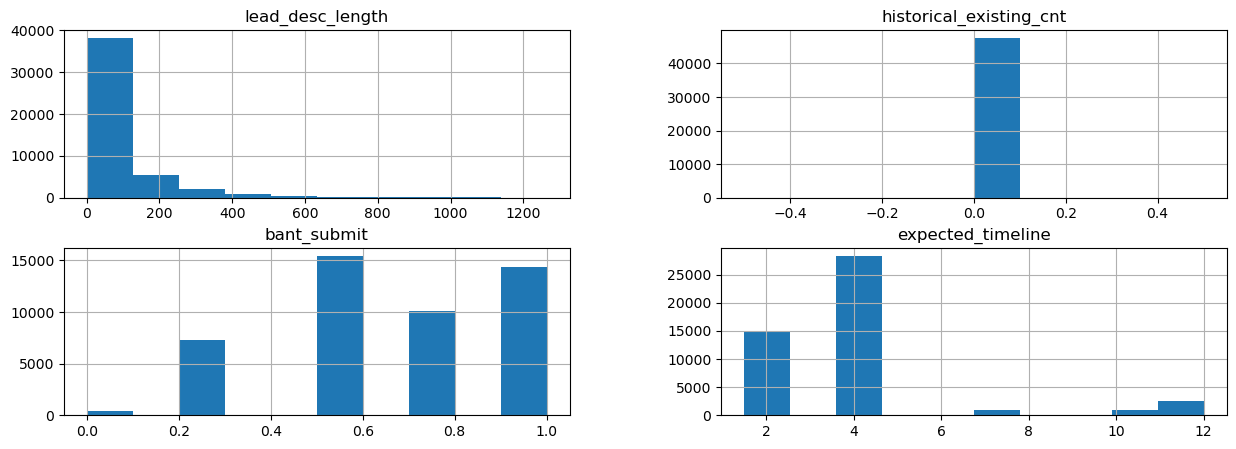

In [188]:
df[["lead_desc_length", "historical_existing_cnt", "bant_submit", "expected_timeline"]].hist(figsize=(15,5))

## 7. Feature Removal

In [189]:
features_to_drop = [
    "response_corporate_num",
    # "id_strategic_ver",
    "it_strategic_ver",
    "idit_strategic_ver",
    "response_corporate_num",
    "lead_owner",
    # "lead_owner_frequency",
    "customer_country.1",
    'product_subcategory',
    "product_modelname",
    "business_subarea",
    'response_corporate',
    'customer_country',
    "customer_type",
    "product_category",
    "business_area",
    "customer_idx",
    'ver_cus',
    'ver_pro',
    #'com_reg_ver_win_rate',
    #'ver_win_rate_x',
    #'ver_win_ratio_per_bu'
    
]

X = X.drop(features_to_drop, axis=1)  # type: ignore
X_test = X_test.drop(features_to_drop, axis=1)  # type: ignore

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [190]:
high_importance_columns = [
    "lead_owner_target",
    "lead_desc_length",
    "historical_existing_cnt",
    "ver_win_rate_x",
    
    "lead_owner_frequency",
    "bant_submit",
    "expected_timeline",
    "com_reg_ver_win_rate",
    "vertical_level1",
    "id_strategic_ver",
]

additional_drop_columns = [
    col
    for col in X.columns
    if col not in high_importance_columns
]

X = X.drop(additional_drop_columns, axis=1)
X_test = X_test.drop(additional_drop_columns, axis=1)

X.columns.tolist()

['lead_desc_length',
 'historical_existing_cnt',
 'bant_submit',
 'expected_timeline',
 'com_reg_ver_win_rate',
 'id_strategic_ver',
 'ver_win_rate_x',
 'lead_owner_frequency',
 'lead_owner_target',
 'vertical_level1']

# Hyperparameter Tuning

In [191]:
def build_catboost_params(trial):
    return {
        "iterations": trial.suggest_int("cat__iterations", 500, 1500),
        "learning_rate": trial.suggest_float("cat__learning_rate", 1e-3, 0.1),
        "depth": trial.suggest_int("cat__depth", 1, 10),
        "subsample": trial.suggest_float("cat__subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("cat__colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("cat__min_data_in_leaf", 1, 100),
        "verbose": False,
        "random_state": RANDOM_STATE,
        "auto_class_weights": "Balanced",
    }


def optimize(X, y, n_trials) -> None:
    def _optimize(trial, X, y):
        model = CatBoostClassifier(**build_catboost_params(trial))
        kfold, scores = StratifiedKFold(n_splits=5), []
        for train_idx, val_idx in kfold.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
            model.fit(X_train, y_train)
            prediction = model.predict(X_val)
            prediction = np.where(prediction == "True", True, False)
            scores.append(f1_score(y_val, prediction))
        return np.mean(scores)

    study = optuna.create_study(direction="maximize")
    study.optimize(
        functools.partial(_optimize, X=X, y=y),  # type: ignore
        n_trials=n_trials,
        n_jobs=-1,
        show_progress_bar=True,
    )
    joblib.dump(study, MODEL_FILE)


if DO_OPTIMIZATION:
    optimize(X, y, n_trials=1)

# Modeling

In [192]:
for col in X.columns:
    print(col)
    print(X[col].head())

param_dict = {
    "cat": {
        "verbose": False,
        "random_state": RANDOM_STATE,
        "auto_class_weights": "Balanced",
    },
}

if DO_OPTIMIZATION:
    optimization_results = joblib.load(MODEL_FILE).best_trial.params
    for key, value in optimization_results.items():
        model, param = [x.strip() for x in key.split("__")]
        param_dict[model][param] = value

model = CatBoostClassifier(**param_dict["cat"])

lead_desc_length
0   -0.130302
1    0.126205
2   -0.175568
3   -0.266100
4    0.133749
Name: lead_desc_length, dtype: float64
historical_existing_cnt
0   -0.199877
1    0.319377
2    6.031173
3   -0.199877
4   -0.199877
Name: historical_existing_cnt, dtype: float64
bant_submit
0    1.27736
1    1.27736
2    1.27736
3    1.27736
4    1.27736
Name: bant_submit, dtype: float64
expected_timeline
0   -0.93126
1   -0.93126
2   -0.93126
3   -0.93126
4   -0.93126
Name: expected_timeline, dtype: float64
com_reg_ver_win_rate
0    0.066667
1    0.066667
2    0.088889
3    0.088889
4    0.088889
Name: com_reg_ver_win_rate, dtype: float64
id_strategic_ver
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: id_strategic_ver, dtype: float64
ver_win_rate_x
0    0.003079
1    0.003079
2    0.003079
3    0.003079
4    0.003079
Name: ver_win_rate_x, dtype: float64
lead_owner_frequency
0    0.007235
1    0.000337
2    0.000675
3    0.000489
4    0.001282
Name: lead_owner_frequency, dtype: float64
lead_owne

# K-Fold Cross Validation

In [193]:
X.columns.tolist()

['lead_desc_length',
 'historical_existing_cnt',
 'bant_submit',
 'expected_timeline',
 'com_reg_ver_win_rate',
 'id_strategic_ver',
 'ver_win_rate_x',
 'lead_owner_frequency',
 'lead_owner_target',
 'vertical_level1']

In [194]:
kfolds, scores = (
    StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True),
    [],
)

for fold_idx, (train_idx, val_idx) in enumerate(kfolds.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    model.fit(X_train, y_train)
    prediction = model.predict(X_val)
    prediction = np.where(prediction == "True", True, False)

    print(f"Accuracy (Fold {fold_idx}): {accuracy_score(y_val, prediction)}")
    print(f"Precision (Fold {fold_idx}): {precision_score(y_val, prediction)}")
    print(f"Recall (Fold {fold_idx}): {recall_score(y_val, prediction)}")
    print(f"F1-Score (Fold {fold_idx}): {f1_score(y_val, prediction)}")
    print(
        f"ROC-AUC Score (Fold {fold_idx}): "
        + f"{roc_auc_score(y_val, model.predict_proba(X_val)[:,1])}\n"
    )

    scores.append(f1_score(y_val, prediction))

print(f"Cross-Validation Average F1-Score: {np.mean(scores)}")

Accuracy (Fold 0): 0.9072512647554806
Precision (Fold 0): 0.4650537634408602
Recall (Fold 0): 0.8917525773195877
F1-Score (Fold 0): 0.6113074204946997
ROC-AUC Score (Fold 0): 0.9661729289142598

Accuracy (Fold 1): 0.9078414839797639
Precision (Fold 1): 0.4672
Recall (Fold 1): 0.9030927835051547
F1-Score (Fold 1): 0.6158172231985941
ROC-AUC Score (Fold 1): 0.9695708727386327

Accuracy (Fold 2): 0.9047217537942664
Precision (Fold 2): 0.4583766909469303
Recall (Fold 2): 0.9082474226804124
F1-Score (Fold 2): 0.6092669432918396
ROC-AUC Score (Fold 2): 0.9679591604896197

Accuracy (Fold 3): 0.9081787521079258
Precision (Fold 3): 0.46843501326259945
Recall (Fold 3): 0.9103092783505154
F1-Score (Fold 3): 0.6185639229422066
ROC-AUC Score (Fold 3): 0.968968030823701

Accuracy (Fold 4): 0.9090142507799983
Precision (Fold 4): 0.47058823529411764
Recall (Fold 4): 0.8989690721649485
F1-Score (Fold 4): 0.6177825008855827
ROC-AUC Score (Fold 4): 0.9661559996705271

Cross-Validation Average F1-Score: 0

In [195]:
# F1-Score: 0.6373173181569636 
# -> (customer_position) 0.6413369684259755 
# -> (customer_job) 0.6469536942063515
# -> (corporate & business_weight) : 0.6485214094132996

# -> (vertical_level1 & target_customer 생성 후 ver_cus 삭제) : 0.6545288217419796
# -> (target_category 생성 후 ver_pro 삭제 ) : 0.6559641169129228

In [196]:
model.feature_importances_

array([17.20476702,  8.93243236,  6.49178589,  3.1404002 ,  4.46130661,
        0.73419814,  9.48659126, 13.55163347, 34.814419  ,  1.18246606])

C:\Users\kjmin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kjmin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kjmin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\kjmin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_d

<Axes: >

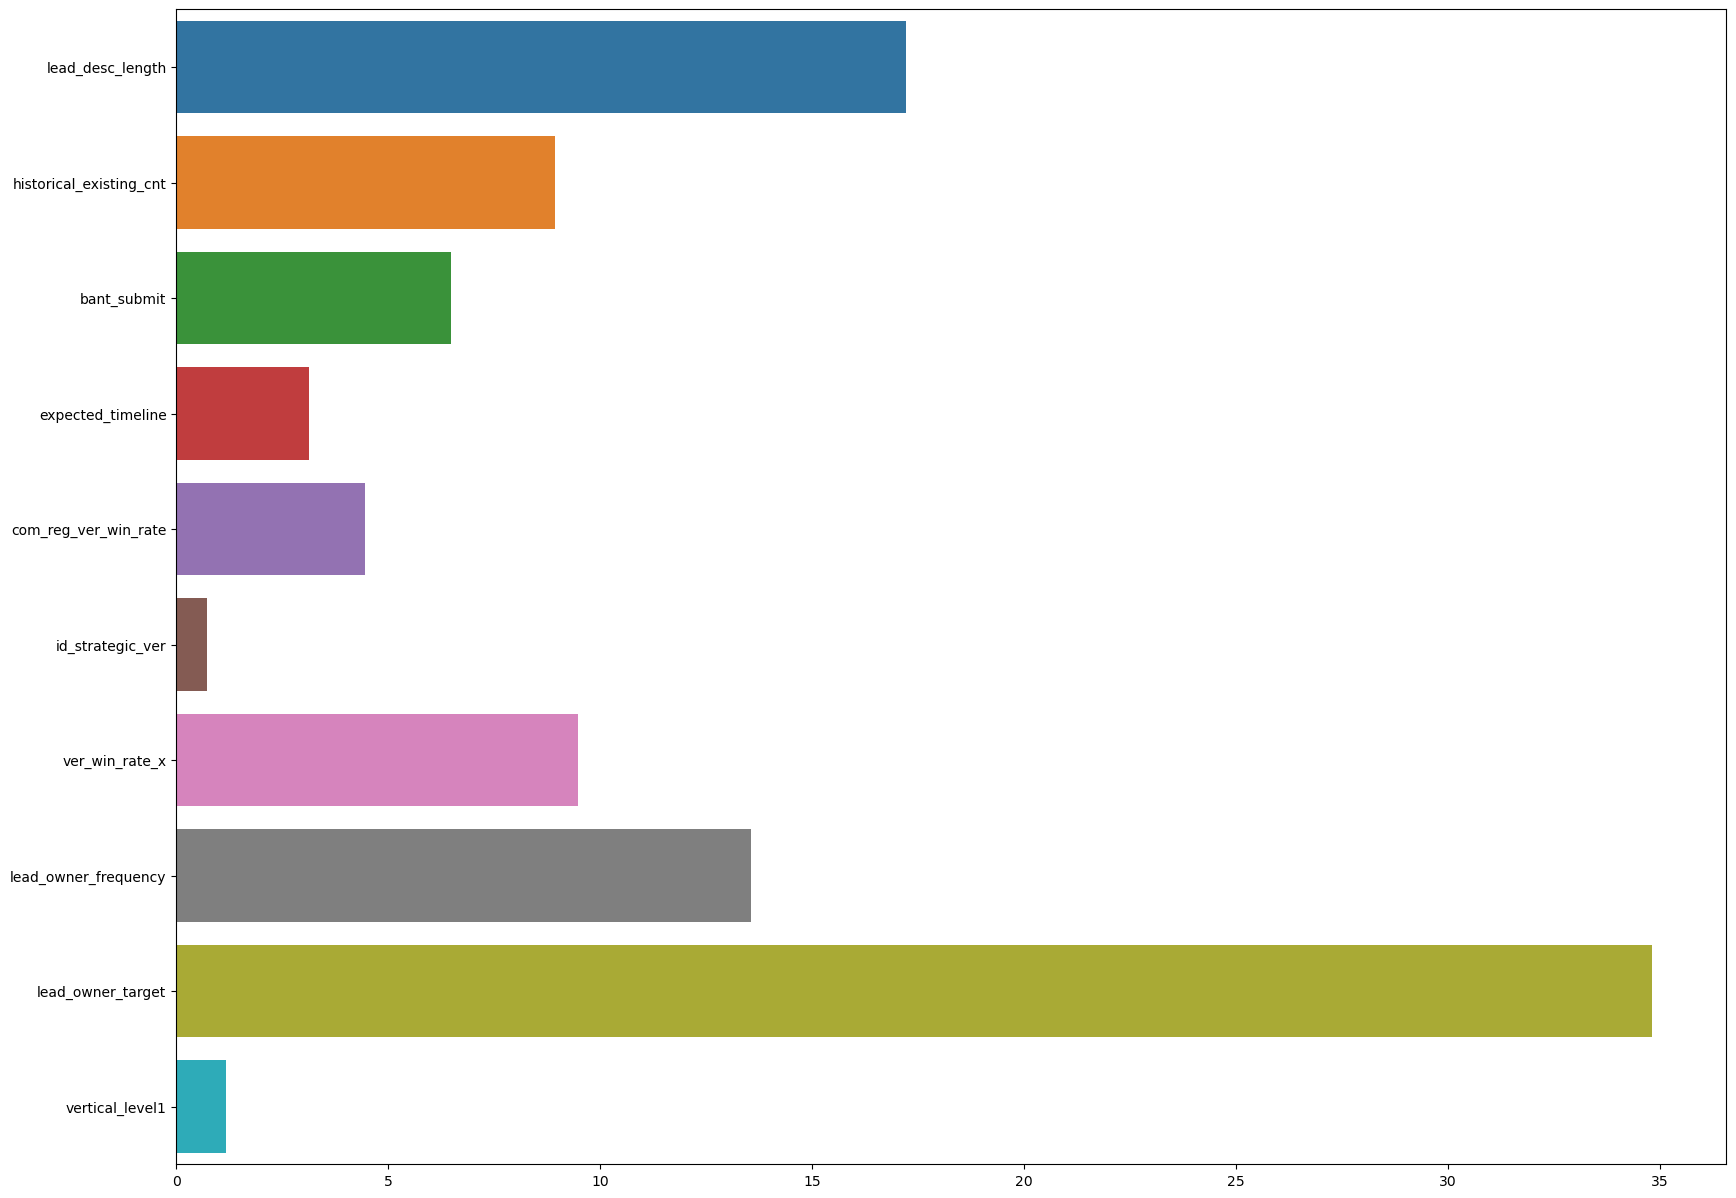

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_names = X.columns.tolist()
plt.figure(figsize=(20,15))
sns.barplot(x=model.feature_importances_, y=feature_names)

# Create Submission

In [198]:
model.fit(X, y)

prediction = model.predict(X_test)
prediction = np.where(prediction == "True", True, False)

df_submission["is_converted"] = prediction
df_submission.to_csv("submission.csv", index=False)
print(df_submission["is_converted"].value_counts())
df_submission.head()

is_converted
False    3953
True     1318
Name: count, dtype: int64


,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,False
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,True
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,False
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,False
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,True
